# ESP32 PLC Watchdog - Experimental Analysis Notebook

This notebook contains the complete analysis pipeline used to evaluate the ESP32-based PLC watchdog.

It supports the experimental analysis for these research questions:

* **RQ1 - Detection of Unauthorized PLC Changes**
* **RQ2 - Detection Latency and Reliability**
* **RQ3 - False Positives and Robustness**

Each experiment logs one `.jsonl` file, containing one poll per line.
This notebook loads that log, flattens the structure, produces tables, metrics, and plots used in the paper.
    

## Test Setup

This section defines all experimental trials for the study. Each scenario uses 5 trials with varying durations (as applicable). For each trial, a JSONL log from the ESP32 is created. The time of any PLC change (to be used as groundtruth) will be recorded manually in the notebook.

### Scenario S1: Baseline (No PLC Changes)

- scenario_id = "S1", scenario_variant = "baseline"
- Target duration per trial = 20 minutes per trial
- change_expected per trail = **False**
- change_type (in logs) = **none**

Notes: This is used for normal behavior and false-positive baseline. PLC logic and parameters are to remain untouched for the entire trial.

**Trial 1 - 5**
Normal lab conditions, Start logging, let system run with typical I/O and process simulation. No edits in Studio 5000. Record start/end wall-clock time

### Scenario S2: Authorized Engineering Change

- scenario_id = "S2", scenario_variant = "authorized_change"
- Target duration per trial = 20 minutes per trial (10 min pre-change, 10 min post-change)
- change_expected per trial = **True**
- change_type (in logs) = **auditvalue** (authorized parameter/logic change)
- Make sure PLC TAG `AuthorizedUser` is enabled

Notes: These trials represent legitimate engineering work. Apply a planned change in Studio 5000 and immediately record the exact timestamp of the change.

- **Trial 1**: Increase a PID Kp gain by a small amount (less than 1).
- **Trial 2**: Apply a larger PID Kp gain.
- **Trial 3**: Go into online edit mode, add a XIO function, then enable changes.
- **Trial 4**: Enable forces in the PLC
- **Trial 5**: Apply a PID Ki change and enable forces

### Scenario S3: Unauthorized / Attack-like Change

- scenario_id = "S3", scenario_variant = "unauthorized_change"
- Target duration per trial = 20 minutes per trial (10 min pre-change, 10 min post-change)
- change_expected per trial = **True**
- change_type (in logs) **auditvalue** (unauthorized parameter/logic change)
- Make sure PLC TAG `AuthorizedUser` is disabled

Notes: These represent malicious or unsafe modifications. Treated as if an attacker is changing the PLC.  

- **Trial 1:** Increase a PID Kp gain by a small amount (less than 1)
- **Trial 2:** Apply a larger PID Kp gain.
- **Trial 3:** Go into online edit mode, add a XIO function, then enable changes.
- **Trial 4:** Enable forces in the PLC
- **Trial 5:** Apply a PID Ki change and enable forces


### Scenario S4: Benign Noise / False-Positive Stress

- scenario_id = "S4", scenario_variant = "benign_noise"
- Target duration per trial = 20 minutes per trial
- change_expected (per trial) = **False**
- change_type (in logs) = none, any detections here are false positives

Notes: Goal is to create benign but noisy conditions without making any edits that should increment `AuditValue` or modify logic/parameters.

- **Trial 1:** Run 20 minutes (changing unmonitored set-points or values.)
- **Trial 2:** Run 20 minutes with added network scans (Nmap on PLC subnet)
- **Trial 3:** Run 20 minutes with background traffic (file transfers on VLAN using other devices)
- **Trial 4:** Run 20 minutes with PLC I/O stress (frequent discrete changes)
- **Trial 5:** Run 20 minutes - Apply all tests from previous trials during this trial

### Scenario S5: Communication Loss / Link Interruption

- scenario_id = "S5", scenario_variant = "comm_loss"
- Target duration per trial = 15 minutes per trial
- change_expected (per trial): **False**
- change_type (in logs): none

Notes: Goal is to test how the watchdog behaves when the ESP32-PLC communication link drops and recovers. There should be no intentional logic or parameter edits.

- **Trial 1:** Start with 5 minutes of normal operation, unplug the network ESP32-PLC network path for less than 1 min, reconnect and run another 10 minutes
- **Trial 2:** Same as trial 1, but longer outage 2 minutes
- **Trial 3:** Start with 2 minutes of normal operation, apply 5, 20 second interruptions during 10-minute window
- **Trial 4:** Same as trial 3, redundant.
- **Trial 5:** Start with 2 minutes of normal operation, change PLC IP address, then change it back.

## Reporting Setup

### Configuration + Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

plt.rcParams["figure.figsize"] = (8,4)

# This file path should change for each experiment
LOG_FILE = "log_test.jsonl"

LOG_FILE

'log_test.jsonl'

### Load All Experiment Logs

Instead of using a single `LOG_FILE`, the experiments may produce multiple `.jsonl` files (e.g., different scenarios and trials). Here we:

1. Use a glob pattern (e.g., `'logs/*.jsonl`) to find all log files
2. Load each file into a temporary `DataFrame`.
3. Add a `source_file` column so we can trace rows back to the file.
4. Concatenate everything into a single `df` for analysis

In [2]:
# Pattern for log files
# Option A: all JSONL files in a folder:
# LOG_GLOB = "logs/*.jsonl"
# Option B: single file in the current folder
# LOG_GLOB = example_log.jsonl

LOG_GLOB = "logs/*.jsonl" # adjust to match folder layout

files = glob.glob(LOG_GLOB)
print("Found log files:")
for f in files:
    print(" ", f)

if not files:
    raise FileNotFoundError(f"No files matched pattern: {LOG_GLOB}")

dfs = []
for f in files:
    temp = pd.read_json(f, lines=True)
    temp["source_file"] = os.path.basename(f)
    dfs.append(temp)

df = pd.concat(dfs, ignore_index=True)

print("Total rows after concatenation:", len(df))
df.head()

Found log files:
  logs\synthetic_full_test_v3.jsonl
Total rows after concatenation: 15


,scenario_id,scenario_variant,trial_id,change_expected,change_type,poll_seq,current,baseline,comparison,comm,groundtruth,metadata,source_file
0,S1,baseline,1,False,none,0,{'auditvalue': 1000},{'auditvalue': 1000},"{'any_change': False, 'auditvalue_changed': Fa...",{'ok': True},{'t_change_groundtruth_iso': None},"{'poll_index': 0, 'poll_period_ms': 200, 'firm...",synthetic_full_test_v3.jsonl
1,S1,baseline,1,False,none,1,{'auditvalue': 1000},{'auditvalue': 1000},"{'any_change': False, 'auditvalue_changed': Fa...",{'ok': True},{'t_change_groundtruth_iso': None},"{'poll_index': 1, 'poll_period_ms': 200, 'firm...",synthetic_full_test_v3.jsonl
2,S1,baseline,1,False,none,2,{'auditvalue': 1000},{'auditvalue': 1000},"{'any_change': False, 'auditvalue_changed': Fa...",{'ok': True},{'t_change_groundtruth_iso': None},"{'poll_index': 2, 'poll_period_ms': 200, 'firm...",synthetic_full_test_v3.jsonl
3,S1,baseline,1,False,none,3,{'auditvalue': 1000},{'auditvalue': 1000},"{'any_change': False, 'auditvalue_changed': Fa...",{'ok': True},{'t_change_groundtruth_iso': None},"{'poll_index': 3, 'poll_period_ms': 200, 'firm...",synthetic_full_test_v3.jsonl
4,S1,baseline,1,False,none,4,{'auditvalue': 1000},{'auditvalue': 1000},"{'any_change': False, 'auditvalue_changed': Fa...",{'ok': True},{'t_change_groundtruth_iso': None},"{'poll_index': 4, 'poll_period_ms': 200, 'firm...",synthetic_full_test_v3.jsonl


### Flatten Dataset

Each row has nested objects:
- `current`
- `baseline`
- `comparison`
- `comm`
- `groundtruth`
- `metadata`

Flattening them makes analysis much easier

In [3]:
flat = pd.concat(
    [
        df.drop(
            columns=["current", "baseline", "comparison", "comm", "groundtruth", "metadata"],
            errors="ignore",
        ),
        pd.json_normalize(df["current"]).add_prefix("current."),
        pd.json_normalize(df["baseline"]).add_prefix("baseline."),
        pd.json_normalize(df["comparison"]).add_prefix("comparison."),
        pd.json_normalize(df["comm"]).add_prefix("comm."),
        pd.json_normalize(df["groundtruth"]).add_prefix("groundtruth."),
        pd.json_normalize(df["metadata"]).add_prefix("metadata."),
    ],
    axis=1,
)

# Ensure basic types used later
if "trial_id" in flat.columns:
    flat["trial_id"] = flat["trial_id"].astype(int)

if "comparison.any_change" in flat.columns:
    flat["comparison.any_change"] = flat["comparison.any_change"].astype(bool)

flat.head()


,scenario_id,scenario_variant,trial_id,change_expected,change_type,poll_seq,source_file,current.auditvalue,baseline.auditvalue,comparison.any_change,comparison.auditvalue_changed,comparison.unauthorized_change,comparison.authorized_change,comm.ok,groundtruth.t_change_groundtruth_iso,metadata.poll_index,metadata.poll_period_ms,metadata.firmware_version,metadata.first_poll_time_iso,metadata.poll_time_iso
0,S1,baseline,1,False,none,0,synthetic_full_test_v3.jsonl,1000,1000,False,False,False,False,True,None,0,200,FW-TEST-1.0,2025-11-27T21:00:00Z,2025-11-27T21:00:00.000Z
1,S1,baseline,1,False,none,1,synthetic_full_test_v3.jsonl,1000,1000,False,False,False,False,True,None,1,200,FW-TEST-1.0,2025-11-27T21:00:00Z,2025-11-27T21:00:00.200Z
2,S1,baseline,1,False,none,2,synthetic_full_test_v3.jsonl,1000,1000,False,False,False,False,True,None,2,200,FW-TEST-1.0,2025-11-27T21:00:00Z,2025-11-27T21:00:00.400Z
3,S1,baseline,1,False,none,3,synthetic_full_test_v3.jsonl,1000,1000,False,False,False,False,True,None,3,200,FW-TEST-1.0,2025-11-27T21:00:00Z,2025-11-27T21:00:00.600Z
4,S1,baseline,1,False,none,4,synthetic_full_test_v3.jsonl,1000,1000,False,False,False,False,True,None,4,200,FW-TEST-1.0,2025-11-27T21:00:00Z,2025-11-27T21:00:00.800Z


In [4]:
if "esp32_timestamp_iso" not in flat.columns and "metadata.poll_time_iso" in flat.columns:
    flat["esp32_timestamp_iso"] = flat["metadata.poll_time_iso"]


**Sanity Check Columns**

In [5]:
sorted(flat.columns)

['baseline.auditvalue',
 'change_expected',
 'change_type',
 'comm.ok',
 'comparison.any_change',
 'comparison.auditvalue_changed',
 'comparison.authorized_change',
 'comparison.unauthorized_change',
 'current.auditvalue',
 'esp32_timestamp_iso',
 'groundtruth.t_change_groundtruth_iso',
 'metadata.firmware_version',
 'metadata.first_poll_time_iso',
 'metadata.poll_index',
 'metadata.poll_period_ms',
 'metadata.poll_time_iso',
 'poll_seq',
 'scenario_id',
 'scenario_variant',
 'source_file',
 'trial_id']

**Sanity check - multiple logs combined**

In [6]:
flat[["source_file", "scenario_id", "trial_id"]].head(20)

,source_file,scenario_id,trial_id
0,synthetic_full_test_v3.jsonl,S1,1
1,synthetic_full_test_v3.jsonl,S1,1
2,synthetic_full_test_v3.jsonl,S1,1
3,synthetic_full_test_v3.jsonl,S1,1
4,synthetic_full_test_v3.jsonl,S1,1
5,synthetic_full_test_v3.jsonl,S2,1
6,synthetic_full_test_v3.jsonl,S2,1
7,synthetic_full_test_v3.jsonl,S2,1
8,synthetic_full_test_v3.jsonl,S2,1
9,synthetic_full_test_v3.jsonl,S2,1


## Experiment 1 - RQ1: Detection of Unauthorized PLC Changes

**Research Question (RQ1):**
Can the embedded watchdog reliably detect modified logic, altered PID parameters, and tampered I/O configuration on a PLC?

Each row in the log corresponds to a single poll. The key fields for this experiment are:  
-`scenario_id` - which high-level experiment scenario (e.g., baseline, logic change, PID tamper, config tamper).  
-`change_type` - which type of change this scenario introduces (e.g., `"logic"`, `"pid"`, `"config"`, `"none"`).   
-`change_expected` - whether we *intend* a change to occur in this scenario at all (True/False).  
-`trial_id` - identifier for a specific run/repetition of a scenario.  
-`comparison.any_change` - did the watchdog detect any change during this poll?  

In this section we will:
1. Inspect how many rows we have per scenario and change type.
2. Compute **poll-level detection rates**.
3. Compute **trial-level detection rates** (did the watchdog detect at least once per trial?).

### Inspect distribution of scenarios and changes types

This will tell us how many samples per `(scenario_id, change_type)` that we have

In [7]:
# 1.1 Basic distribution of scenarios and change types

scenario_counts = (
    flat
    .groupby(["scenario_id", "change_type"])
    .size()
    .rename("rows")
    .reset_index()
)

scenario_counts

,scenario_id,change_type,rows
0,S1,none,5
1,S2,auditvalue,5
2,S3,none,5


### Poll-level detection rates

We will treat each row as one "poll" and see how often `comparison.any_change` is true. 

Interpretation:  
- `polls` = total number of polls in that scenario/type.  
- `detections` = number of polls where the watchdog said "change detected".  
- `detection_rate` = fraction of polls with detection.

Later, these become a table like "Poll-level detection rate by scenario"

In [8]:
# 1.2 Poll-level detection rates by scenario and change_type

# Ensure the flag is boolean
detected = flat["comparison.any_change"].astype(bool)

agg_rq1_polls = (
    flat.assign(detected=detected)
    .groupby(["scenario_id", "change_type"])
    .agg(
        polls=("poll_seq", "count"),
        detections=("detected", "sum"),
    )
    .reset_index()
)

agg_rq1_polls["detection_rate"] = agg_rq1_polls["detections"] / agg_rq1_polls["polls"]
agg_rq1_polls

,scenario_id,change_type,polls,detections,detection_rate
0,S1,none,5,0,0.0
1,S2,auditvalue,5,2,0.4
2,S3,none,5,3,0.6


### Trial level detection (did we catch it at least once per run?)

We typically want to know: per `trial_id`, did we detect at least once?

Interpretation:  
- Each row is (scenario, change_type, trial_id)
- `any_detection` is True if any poll in that trial flagged a change

In [9]:
# 1.3 Trial-level detection: did we detect at least once per trial?

trial_detection = (
    flat.assign(detected=detected)
    .groupby(["scenario_id", "change_type", "trial_id"])
    .agg(
        polls=("poll_seq", "count"),
        any_detection=("detected", "max"), 
    )
    .reset_index()
)

trial_detection.head()

,scenario_id,change_type,trial_id,polls,any_detection
0,S1,none,1,5,False
1,S2,auditvalue,1,5,True
2,S3,none,1,5,True


### Trial level detection rate summary

Now aggregate over trials to see percentage of trials where the watchdog caught something at least once.

This is often the most "headline" table for RQ1:

Interpretation:  
- In scenario `logic_change`, the watchdog detected in X% of trials.
- In PID tampering scenario, the trial-level detection rate was Y%, etc.

In [10]:
# 1.4 Scenario-level trial detection rates

agg_rq1_trials = (
    trial_detection
    .groupby(["scenario_id", "change_type"])
    .agg(
        trials=("trial_id", "nunique"),
        trials_with_detection=("any_detection", "sum"),
    )
    .reset_index()
)

agg_rq1_trials["trial_detection_rate"] = (
    agg_rq1_trials["trials_with_detection"] / agg_rq1_trials["trials"]
)

agg_rq1_trials

,scenario_id,change_type,trials,trials_with_detection,trial_detection_rate
0,S1,none,1,0,0.0
1,S2,auditvalue,1,1,1.0
2,S3,none,1,1,1.0


### Notes for Interpreting RQ1 tables

When real data is collected, interpret the above tables as follows:

- `agg_rq1_polls` (poll-level):
    - High `detection_rate` means the watchdog is consistently flagging changes on most polls.  
    - If detection rate is very low for a given `change_type`, that suggests poor sensitivity to that class of change.
      
- `agg_rq1_trials` (trial-level):
    - `trial_detection_rate` close to 1.0 means the watchdog almost always detects the change at least once in each trial.
    - Values significantly below 1.0 indicate scenarios where some trials had changes but were never detected.

Compare behavior across:
- `logic` vs `pid` vs `config` change types.
- Different `scenario_id` variants (e.g., simple vs subtle modifications).

## Experiment 2 - RQ2: Detection Latency and Reliability

**RQ2:** What is the latency between an actual PLC change and the watchdog's detection of that change?  

We assume each **trail** contains exactly one intentional change (attack). The ground truth timing is encoded in:  
- `groundtruth.t_change_groundtruth_iso` - timestamp when change was applied.
- `groundtruth.t_change_marker_seen` - timestamp when the watchdog first observed the change (e.g., first poll with `comparison.any_change == True` for that trial).

For trials where both stamps are available, we define:
$$\text{latency\_ms} = (t_\text{marker\_seen} - t_\text{groundtruth}) \text{ (in milliseconds)}$$

This section computes latency per trial and summarizes it by `scenario_id` and `change_type`.

### Groundtruth: per-trial PLC change timestamps

In [11]:
# Manual groundtruth timestamps for change trials.
# Key:   (scenario_id, trial_id)
# Value: ISO-8601 timestamp string when the PLC change was applied.
#
# Example (replace with real values from your experiments):
# GROUNDTRUTH_CHANGE_TIMES = {
#     ("S2", 1): "2025-11-26T14:22:05.000Z",
# }

GROUNDTRUTH_CHANGE_TIMES = {
    ("S2", 1): "2025-11-27T21:04:59.800Z"
}

In [12]:
# Fill groundtruth.t_change_groundtruth_iso for each trial from the manual mapping.
def groundtruth_time(row):
    key = (row.get("scenario_id", None), int(row.get("trial_id", 0)))
    if key in GROUNDTRUTH_CHANGE_TIMES:
        return GROUNDTRUTH_CHANGE_TIMES[key]
    # Fall back to whatever is in the log (usually "NA")
    return row.get("groundtruth.t_change_groundtruth_iso", "NA")

flat["groundtruth.t_change_groundtruth_iso"] = flat.apply(
    groundtruth_time,
    axis=1,
)

flat[[
    "scenario_id",
    "trial_id",
    "groundtruth.t_change_groundtruth_iso",
]].head()


,scenario_id,trial_id,groundtruth.t_change_groundtruth_iso
0,S1,1,None
1,S1,1,None
2,S1,1,None
3,S1,1,None
4,S1,1,None


In [13]:
# Initialize marker_seen to "NA" everywhere
flat["groundtruth.t_change_marker_seen"] = "NA"

# For each (scenario_id, trial_id) that has a defined change time,
# find the first detection and use its ESP32 timestamp as marker_seen.
for (scenario, trial), group in flat.groupby(["scenario_id", "trial_id"]):
    key = (scenario, int(trial))
    gt_iso = GROUNDTRUTH_CHANGE_TIMES.get(key)
    if gt_iso is None:
        # No intentional change recorded for this trial
        continue

    # All rows where watchdog saw any change
    if "comparison.any_change" not in group.columns:
        continue

    det_rows = group[group["comparison.any_change"].astype(bool)]
    if det_rows.empty:
        # No detection in this trial; leave marker_seen as "NA"
        continue

    # First detection in that trial
    first_det = det_rows.iloc[0]
    marker_iso = first_det["esp32_timestamp_iso"]

    # Write this marker to all rows for that trial
    mask = (
        (flat["scenario_id"] == scenario)
        & (flat["trial_id"] == trial)
    )
    flat.loc[mask, "groundtruth.t_change_marker_seen"] = marker_iso

flat[[
    "scenario_id",
    "trial_id",
    "groundtruth.t_change_groundtruth_iso",
    "groundtruth.t_change_marker_seen",
]].head()


,scenario_id,trial_id,groundtruth.t_change_groundtruth_iso,groundtruth.t_change_marker_seen
0,S1,1,None,NA
1,S1,1,None,NA
2,S1,1,None,NA
3,S1,1,None,NA
4,S1,1,None,NA


### Filter rows that have valid groundtruth timestamps

In [14]:
# 2.1 Select rows where both groundtruth timestamps are present and not "NA"
# RQ2 – Step 1: select rows with both groundtruth timestamps present and not "NA"
mask_gt = (
    flat["groundtruth.t_change_groundtruth_iso"].notna()
    & (flat["groundtruth.t_change_groundtruth_iso"] != "NA")
    & flat["groundtruth.t_change_marker_seen"].notna()
    & (flat["groundtruth.t_change_marker_seen"] != "NA")
)

latency_df = flat.loc[mask_gt].copy()
print("Rows with valid groundtruth timing:", len(latency_df))

latency_df[[
    "scenario_id",
    "change_type",
    "trial_id",
    "groundtruth.t_change_groundtruth_iso",
    "groundtruth.t_change_marker_seen",
]].head()


Rows with valid groundtruth timing: 5


,scenario_id,change_type,trial_id,groundtruth.t_change_groundtruth_iso,groundtruth.t_change_marker_seen
5,S2,auditvalue,1,2025-11-27T21:04:59.800Z,2025-11-27T21:05:00.600Z
6,S2,auditvalue,1,2025-11-27T21:04:59.800Z,2025-11-27T21:05:00.600Z
7,S2,auditvalue,1,2025-11-27T21:04:59.800Z,2025-11-27T21:05:00.600Z
8,S2,auditvalue,1,2025-11-27T21:04:59.800Z,2025-11-27T21:05:00.600Z
9,S2,auditvalue,1,2025-11-27T21:04:59.800Z,2025-11-27T21:05:00.600Z


### Compute latency in milliseconds

In [15]:
# 2.2 Compute latency_ms when timestamps are available
# RQ2 – Step 2: compute latency_ms per log row having valid timestamps
if len(latency_df) > 0:
    latency_df["t_groundtruth"] = pd.to_datetime(
        latency_df["groundtruth.t_change_groundtruth_iso"], utc=True
    )
    latency_df["t_marker_seen"] = pd.to_datetime(
        latency_df["groundtruth.t_change_marker_seen"], utc=True
    )

    latency_df["latency_ms"] = (
        latency_df["t_marker_seen"] - latency_df["t_groundtruth"]
    ).dt.total_seconds() * 1000.0

    latency_df[[
        "scenario_id",
        "change_type",
        "trial_id",
        "latency_ms",
    ]].head()
else:
    print(
        "No rows with valid groundtruth timing yet. "
        "Populate GROUNDTRUTH_CHANGE_TIMES for change trials."
    )


### Summarize latency by scenario and change type

In [16]:
# 2.3 Latency summary by scenario and change type
# RQ2 – Step 3: aggregate latency per scenario_id + change_type
if ("latency_ms" in latency_df.columns) and (len(latency_df) > 0):
    agg_lat = (
        latency_df
        .groupby(["scenario_id", "change_type"])
        .agg(
            n=("latency_ms", "count"),
            mean_latency_ms=("latency_ms", "mean"),
            median_latency_ms=("latency_ms", "median"),
            p90_latency_ms=("latency_ms", lambda s: s.quantile(0.90)),
            p99_latency_ms=("latency_ms", lambda s: s.quantile(0.99)),
        )
        .reset_index()
    )
    agg_lat
else:
    print("Latency data not yet available (no trials with both groundtruth and detection).")


In [17]:
# Optional: sanity check that each manual groundtruth time lies within
# the ESP log window for that trial.

for (scenario, trial), t_iso in GROUNDTRUTH_CHANGE_TIMES.items():
    trial_rows = flat[
        (flat["scenario_id"] == scenario)
        & (flat["trial_id"] == trial)
    ]

    print(f"Trial: ({scenario}, {trial})")

    if trial_rows.empty:
        print("WARNING: no rows found for this trial in the log.\n")
        continue

    t_ground = pd.to_datetime(t_iso, utc=True)
    t_min = pd.to_datetime(trial_rows["esp32_timestamp_iso"].min(), utc=True)
    t_max = pd.to_datetime(trial_rows["esp32_timestamp_iso"].max(), utc=True)

    print(f"Groundtruth time:  {t_ground}")
    print(f"ESP log window:    {t_min} → {t_max}")

    if not (t_min <= t_ground <= t_max):
        print("  WARNING: groundtruth time is outside ESP log window!\n")
    else:
        print("groundtruth time is within ESP log window.\n")


Trial: (S2, 1)
Groundtruth time:  2025-11-27 21:04:59.800000+00:00
ESP log window:    2025-11-27 21:05:00+00:00 → 2025-11-27 21:05:00.800000+00:00



### Visualize latency distribution

This provides a histogram of how fast the watchdog reacts overall.

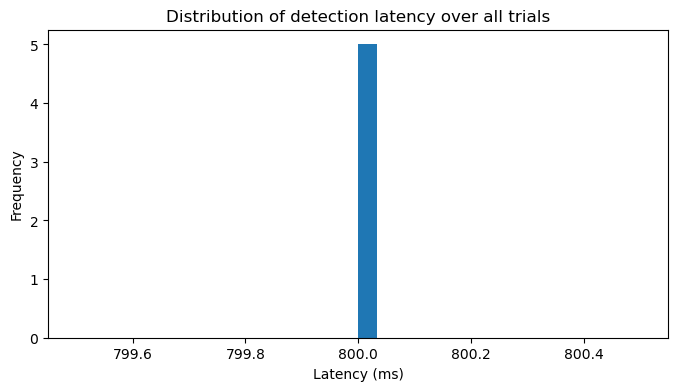

In [18]:
# 2.4 Latency distribution plot

if "latency_ms" in latency_df.columns and len(latency_df) > 0:
    latency_df["latency_ms"].plot(kind="hist", bins=30)
    plt.xlabel("Latency (ms)")
    plt.title("Distribution of detection latency over all trials")
    plt.show()
else:
    print("No valid groundtruth timing rows yet. Populate GROUNDTRUTH_CHANGE_TIMES for change trials.")

To provide a per-scenario plot, provide the scenario_id below

In [19]:
# Example for specific scenario:
# scenario_mask = latency_df["scenario_id"] == "pid_tamper_basic"
# latency_df.loc[scenario_mask, "latency_ms"].plot(kind="hist", bins=30)

### Interpretation Notes

Latency data can show:

- `mean_latency_ms` and `median_latency_ms` show typical detection speed.
- `p90_latency_ms` and `p99_latency_ms` show worst-case behavior in the tail.
- Compare latency between:
    - logic changes,
    - PID parameter changes,
    - configuration changes.

These values can be related to:
- The polling period (`metadata.poll_period_ms`).
- Any PLC-side delays or scan time.
- Practical requirements (e.g., "latency under 1 second is acceptable for this use case").

## Experiment 3 - RQ3: False Positives and Robustness

**RQ3:** How resilient is the watchdog to false positives cause by legitimate changes or electrical/network noise?

In this experiment we focus on **trials where no unauthorized change is supposed to occur**, such as:  
- Baseline operation (no changes at all)
- Benign disturbances (e.g., noise, minor harmless fluctuations).

Key fields:  
- `change_expected` - whether this trial is intended to contain an actual (unauthorized) change.
- `comparison.any_change` - watchdog says "something changed" this poll.
- `comparison.unauthorized_change` - watchdog thinks this change is unauthorized.
- `comparison.authorized_change` - watchdog things the change is authorized.

In benign scenarios (`change_expected == False`), any `comparison.any_change == True` is a **false positive**.

### Define the benign subset

In [20]:
# 3.1 Define benign subset (no change expected)

mask_benign = (flat["change_expected"] == False)

benign_df = flat.loc[mask_benign].copy()
print("Benign rows (no change expected):", len(benign_df))

benign_df[[
    "source_file",
    "scenario_id",
    "trial_id",
    "change_expected",
    "comparison.any_change",
    "comparison.unauthorized_change",
    "comparison.authorized_change",
]].head(10)

Benign rows (no change expected): 10


,source_file,scenario_id,trial_id,change_expected,comparison.any_change,comparison.unauthorized_change,comparison.authorized_change
0,synthetic_full_test_v3.jsonl,S1,1,False,False,False,False
1,synthetic_full_test_v3.jsonl,S1,1,False,False,False,False
2,synthetic_full_test_v3.jsonl,S1,1,False,False,False,False
3,synthetic_full_test_v3.jsonl,S1,1,False,False,False,False
4,synthetic_full_test_v3.jsonl,S1,1,False,False,False,False
10,synthetic_full_test_v3.jsonl,S3,1,False,False,False,False
11,synthetic_full_test_v3.jsonl,S3,1,False,False,False,False
12,synthetic_full_test_v3.jsonl,S3,1,False,True,True,False
13,synthetic_full_test_v3.jsonl,S3,1,False,True,True,False
14,synthetic_full_test_v3.jsonl,S3,1,False,True,True,False


### Poll-level false positive rate

Here we ask: among all polls where no change is expected, how often did the watchdog fire?

Interpretation:
- If this is near 0, the watchdog rarely fires when nothing should happen
- If this is higher, there are issues causing false positives.

In [21]:
# 3.2 Poll-level false positive rate in benign rows

if len(benign_df) > 0:
    benign_df = benign_df.assign(
        fp_poll = benign_df["comparison.any_change"].astype(bool)
    )
    fp_rate_poll = benign_df["fp_poll"].mean()
    print(f"Poll-level false positive rate (benign subset): "
            f"{fp_rate_poll:.4f} ({fp_rate_poll*100:.2f}%)")
else:
    print("No benign rows found. Adjust mask_benign if needed.")

Poll-level false positive rate (benign subset): 0.3000 (30.00%)


### Trial-level false alarms

This looks at how many trials did we see at least one false alarm

Interpretation:
Each row is one trial:
- `polls` = number of polls in the trial
- `any_fp` = did any poll generate a false positive

In [22]:
# 3.3 Trial-level false alarm rate in benign scenarios

if len(benign_df) > 0:
    trial_fp = (
        benign_df
        .assign(fp_poll = benign_df["comparison.any_change"].astype(bool))
        .groupby(["scenario_id", "trial_id"])
        .agg(
            polls=("poll_seq", "count"),
            any_fp=("fp_poll", "max"),
        )
        .reset_index()
    )
    trial_fp.head()
else:
    print("No benign rows found. Adjust mask_benign if needed.")

### Trial-level false alarm rate per scenario

Aggregate by `scenario_id`

This shows:
 - how many trials were ran
 - in how many of those trials were there at least one false alarm
 - the fraction (`trial_fp_rate`), which is a key RQ3 number

In [23]:
# 3.4 Aggregate trial-level false alarm rate per benign scenario

if len(benign_df) > 0:
    agg_trial_fp = (
        trial_fp
        .groupby(["scenario_id"])
        .agg(
            trials=("trial_id", "nunique"),
            trials_with_fp=("any_fp", "sum"),
        )
        .reset_index()
    )
    agg_trial_fp["trial_fp_rate"] = (
        agg_trial_fp["trials_with_fp"] / agg_trial_fp["trials"]
    )
    agg_trial_fp
else:
    print("No benign rows found. Adjust mask_benign if needed.")

### Interpretation Notes

- **Poll-level false positive rate** (`fp_rate_poll`):
    - How often does the watchdog fire on individual polls when `change_expected == False`?
    - Very low values are desirable, especially if the watchdog is used for frequent alerts.
    
- **Trial-level false alarm rate** (`trial_fp_rate` per `scenario_id`):
    - In what fraction of benign trials did the watchdog ever raise an alarm?  
    - This is a good way to summarize annoyance alarms


## 7. Experimental Notes — How to Produce the Required Data in Practice

To ensure that RQ1, RQ2, and RQ3 analyses work correctly, the ESP32 watchdog
and PLC must produce logs that contain **complete scenario metadata** and
**accurate ground truth timestamps**. This section documents the required
experiment procedure and the values that must be populated in each trial.

### 7.1 Required Fields Per Trial

Each `.jsonl` log must consistently contain the following metadata:

- **Scenario Identity**
  - `scenario_id` — high-level experiment class (e.g., `"baseline"`, `"logic_change"`)
  - `scenario_variant` — optional refinement (e.g., `"simple"`, `"subtle"`)
  - `trial_id` — the trial number for this scenario

- **Expectation / Ground Truth**
  - `change_expected` — `true` if the trial includes one intentional change
  - `change_type` — `"logic"`, `"pid"`, `"config"`, `"none"` (for baseline trials)

- **Ground Truth Timing**
  - `groundtruth.t_change_groundtruth_iso` — when the PLC change was applied
  - `groundtruth.t_change_marker_seen` — timestamp of the **first watchdog detection**
    matching that change  
    (you will fill this in later by post-processing if necessary)

These fields allow the notebook to compute:
- detection rates (RQ1)
- latency (RQ2)
- false positive rates (RQ3)

### 7.2 Trial Structure (One Change per Trial)

Each trial should follow the same procedure:

1. **Start ESP32 logging**  
   Begin recording JSONL output from the watchdog.

2. **Allow stabilization**  
   Let the system run for ~3–5 seconds so the ESP32 obtains a clean baseline.

3. **Inject exactly one PLC change (if `change_expected = true`)**  
   Examples:
   - Add/remove a rung of ladder logic  
   - Modify a PID gain  
   - Change an I/O mapping or timer preset  

4. **Record the ground truth timestamp**  
   Capture the moment when the change was applied:


This should reflect the actual wall-clock (or PLC clock) moment of the edit.

5. **Continue logging until the watchdog detects the change**  
The watchdog’s earliest detection is used to compute latency (RQ2).  
Later you will fill:



6. **Stop logging and save the `.jsonl` file**  
Store it under a filename encoding scenario and trial:



7. **Repeat for the desired number of trials**  
Typical sets:
- 10 logic-change trials  
- 10 PID tamper trials  
- 10 configuration tamper trials  
- 10 baseline/no-change trials  
(extra noise/disturbance trials optional)

### 7.3 Baseline / Benign Trials (`change_expected = false`)

These trials contain no intentional PLC modifications.  
They are critical for evaluating **false positives** (RQ3).

Procedure:
- Start ESP logging  
- Allow system to run untouched for a fixed duration (e.g., 10–20 seconds)  
- Stop logging  
- Set:



Any `comparison.any_change == true` during these trials is a false alarm.

### 7.4 Authorized-Change Trials (Optional)

If you wish to evaluate whether the watchdog correctly distinguishes
authorized vs unauthorized actions:

- Modify the PLC in a way that your logic marks as “authorized”
- Set:


- Ensure your PLC logic updates:
- `AuthorizedUser`
- `AuditValue` in the proper way

These trials help measure misclassification (e.g., treating authorized edits as unauthorized).

### 7.5 Summary of Experiment Requirements

- **Exactly one intentional PLC change per trial** (except baseline trials).
- **Record scenario metadata** before starting each trial.
- **Record the ground truth timestamp** when the change is applied.
- **Run the watchdog long enough** to observe at least one detection.
- **Save each trial as its own `.jsonl` log**.
- **Keep naming and scenario metadata consistent** for reproducible analysis.

Following this procedure ensures that the RQ1, RQ2, and RQ3 sections of this
notebook produce valid, interpretable, and publication-ready results.


## 8. TEST SETUP




In [24]:
print("DONE")

DONE
